In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial

In [3]:
tfidf_path = '../../data/tfidf_longcent/'

In [4]:
lda_path = '../../data/lda_jsd_toprev_conlen/'

In [5]:
fandom_list = [i for i in os.listdir(tfidf_path) if 'tsv' in i]

In [6]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

## Aggregate

In [7]:
def create_normed_dfs(df, field):

#     Normalize by log scale
    df = df.replace([np.inf, -np.inf], np.nan)
    df[field].fillna(0, inplace=True)
    df[field] = np.log(df[field]+0.001)

#     # turn into z scores
    if field == 'Comments':
        df = df.replace([np.inf, -np.inf], np.nan)
        df[field].dropna()
        df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)
    
    else:
        df[field] = df[field]/df['Chapters']
        df = df.replace([np.inf, -np.inf], np.nan)
        df[['Chapters',field ]].dropna()
        df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)

    return df

In [8]:
def create_dict(df, nov_field, suc_field, binsize):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    vmin = min(df[nov_field].tolist())
    vmax = max(df[nov_field].tolist())
    dic = {}
    for i in np.arange(vmin, vmax, binsize):
        df_s = df[(df[nov_field] >= i) & (df[nov_field] < i+binsize)]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            dic[i] = bootstrap_resample(li)
    return dic

In [9]:
def generate_res(path, nov_field, suc_field, binsize):
    df_all = []
    fandom_list = [i for i in os.listdir(path) if 'tsv' in i]
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(path,fandom), sep = '\t')
        df = create_normed_dfs(df, suc_field)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[[nov_field, suc_field]].dropna()
        df_all.append(df)

    df = pd.concat(df_all)
    df = df.sort_values(by = nov_field)[:-5]
    df = df.sort_values(by = suc_field)[:-5]
    dic = create_dict(df, nov_field, suc_field, binsize)

    return dic
    

In [12]:
lda_kudos_dict = generate_res(lda_path, 'JSD','Kudos', 0.05)
lda_hits_dict = generate_res(lda_path, 'JSD','Hits',0.05)
lda_comments_dict = generate_res(lda_path, 'JSD','Comments',0.05)
lda_bookmarks_dict = generate_res(lda_path, 'JSD','Bookmarks',0.05)

In [22]:
lda_bookmarks_dict

{0.3082585991310225: (0.25613222891358306,
  0.030156511158730966,
  0.4622791937332811),
 0.3582585991310225: (0.1542482608961184,
  0.08466321055558211,
  0.22409172985179285),
 0.40825859913102247: (0.14896020075369276,
  0.12917853081963113,
  0.17127062423384756),
 0.45825859913102246: (0.14538005319097408,
  0.1354643978562313,
  0.1551299764390948),
 0.5082585991310224: (0.09007050087110215,
  0.08441975453055024,
  0.0960320337827956),
 0.5582585991310225: (0.017345823482413012,
  0.013457585257803729,
  0.02154186997761493),
 0.6082585991310224: (-0.05393207608798079,
  -0.057790642368085794,
  -0.050433837445497696),
 0.6582585991310224: (-0.07931929820455152,
  -0.09125856662408949,
  -0.0680088125032729)}

In [13]:
tfidf_kudos_dict = generate_res(tfidf_path, 'Cos', 'Kudos', 0.1)
tfidf_hits_dict = generate_res(tfidf_path, 'Cos', 'Hits', 0.1)
tfidf_comments_dict = generate_res(tfidf_path, 'Cos', 'Comments', 0.1)
tfidf_bookmarks_dict = generate_res(tfidf_path, 'Cos', 'Bookmarks', 0.1)

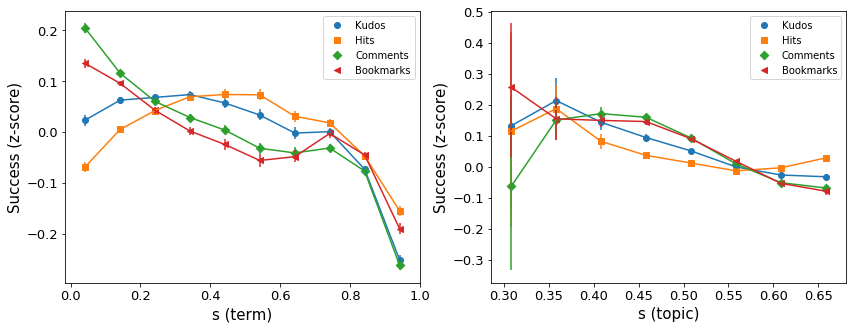

In [14]:
plt.figure(figsize=(14,5))


plt.subplot(1, 2, 1)

tfidf_kudos_x = sorted(tfidf_kudos_dict.keys())
tfidf_kudos_y = [tfidf_kudos_dict[j][0] for j in tfidf_kudos_x]
lower_error = [tfidf_kudos_dict[j][0] - tfidf_kudos_dict[j][1] for j in tfidf_kudos_x]
upper_error = [tfidf_kudos_dict[j][2] - tfidf_kudos_dict[j][0] for j in tfidf_kudos_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_kudos_x, tfidf_kudos_y, yerr=asymmetric_error)
plt.scatter(tfidf_kudos_x, tfidf_kudos_y, label = 'Kudos')

tfidf_hits_x = sorted(tfidf_hits_dict.keys())
tfidf_hits_y = [tfidf_hits_dict[j][0] for j in tfidf_hits_x]
lower_error = [tfidf_hits_dict[j][0] - tfidf_hits_dict[j][1] for j in tfidf_hits_x]
upper_error = [tfidf_hits_dict[j][2] - tfidf_hits_dict[j][0] for j in tfidf_hits_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_hits_x, tfidf_hits_y, yerr=asymmetric_error)
plt.scatter(tfidf_hits_x, tfidf_hits_y,marker='s', label = 'Hits')

tfidf_comments_x = sorted(tfidf_comments_dict.keys())
tfidf_comments_y = [tfidf_comments_dict[j][0] for j in tfidf_kudos_x]
lower_error = [tfidf_comments_dict[j][0] - tfidf_comments_dict[j][1] for j in tfidf_comments_x]
upper_error = [tfidf_comments_dict[j][2] - tfidf_comments_dict[j][0] for j in tfidf_comments_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_comments_x, tfidf_comments_y, yerr=asymmetric_error)
plt.scatter(tfidf_comments_x, tfidf_comments_y, marker='D', label = 'Comments')

tfidf_bookmarks_x = sorted(tfidf_bookmarks_dict.keys())
tfidf_boomkarks_y = [tfidf_bookmarks_dict[j][0] for j in tfidf_bookmarks_x]
lower_error = [tfidf_bookmarks_dict[j][0] - tfidf_bookmarks_dict[j][1] for j in tfidf_bookmarks_x]
upper_error = [tfidf_bookmarks_dict[j][2] - tfidf_bookmarks_dict[j][0] for j in tfidf_bookmarks_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_bookmarks_x, tfidf_boomkarks_y, yerr=asymmetric_error)
plt.scatter(tfidf_bookmarks_x, tfidf_boomkarks_y, marker = '<', label = 'Bookmarks')
""
plt.legend()
plt.xlabel('s (term)',fontsize=15)
plt.ylabel('Success (z-score)',fontsize=15)
plt.tick_params(labelsize=13)


plt.subplot(1, 2, 2)

# for dic in [lda_kudos_dict, lda_hits_dict, lda_comments_dict, lda_bookmarks_dict]:

lda_kudos_x = sorted(lda_kudos_dict.keys())
lda_kudos_y = [lda_kudos_dict[j][0] for j in lda_kudos_x]
lower_error = [lda_kudos_dict[j][0] - lda_kudos_dict[j][1] for j in lda_kudos_x]
upper_error = [lda_kudos_dict[j][2] - lda_kudos_dict[j][0] for j in lda_kudos_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_kudos_x, lda_kudos_y, yerr=asymmetric_error)
plt.scatter(lda_kudos_x, lda_kudos_y,label = 'Kudos')

lda_hits_x = sorted(lda_hits_dict.keys())
lda_hits_y = [lda_hits_dict[j][0] for j in lda_hits_x]
lower_error = [lda_hits_dict[j][0] - lda_hits_dict[j][1] for j in lda_hits_x]
upper_error = [lda_hits_dict[j][2] - lda_hits_dict[j][0] for j in lda_hits_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_hits_x, lda_hits_y, yerr=asymmetric_error)
plt.scatter(lda_hits_x, lda_hits_y,marker='s', label = 'Hits')

lda_comments_x = sorted(lda_comments_dict.keys())
lda_comments_y = [lda_comments_dict[j][0] for j in lda_kudos_x]
lower_error = [lda_comments_dict[j][0] - lda_comments_dict[j][1] for j in lda_comments_x]
upper_error = [lda_comments_dict[j][2] - lda_comments_dict[j][0] for j in lda_comments_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_comments_x, lda_comments_y, yerr=asymmetric_error)
plt.scatter(lda_comments_x, lda_comments_y, marker='D', label = 'Comments')

lda_bookmarks_x = sorted(lda_bookmarks_dict.keys())
lda_bookmarks_y = [lda_bookmarks_dict[j][0] for j in lda_bookmarks_x]
lower_error = [lda_bookmarks_dict[j][0] - lda_bookmarks_dict[j][1] for j in lda_bookmarks_x]
upper_error = [lda_bookmarks_dict[j][2] - lda_bookmarks_dict[j][0] for j in lda_bookmarks_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_bookmarks_x, lda_bookmarks_y, yerr=asymmetric_error )
plt.scatter(lda_bookmarks_x, lda_bookmarks_y, marker = '<', label = 'Bookmarks')
plt.tick_params(labelsize=13)

plt.legend()
plt.xlabel('s (topic)', fontsize = 15)
plt.ylabel('Success (z-score)', fontsize = 15)
plt.savefig('scatter_all_log_longcent.pdf', type='pdf')


In [33]:
df_all = []
fandom_list = [i for i in os.listdir(tfidf_path) if 'tsv' in i]
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(tfidf_path,fandom), sep = '\t')
    df_all.append(df)
    
df_all = pd.concat(df_all)

(array([7.00646e+05, 6.08000e+02, 3.00000e+01, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([    0. ,  3750.5,  7501. , 11251.5, 15002. , 18752.5, 22503. ,
        26253.5, 30004. , 33754.5, 37505. ]),
 <a list of 10 Patch objects>)

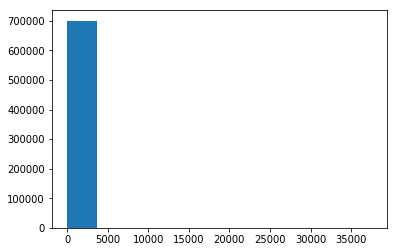

In [34]:
df_all = df_all.replace([np.inf, -np.inf], np.nan)

df_all = df_all.fillna(0)

plt.hist(df_all['Kudos'])

(array([1.20730e+04, 0.00000e+00, 0.00000e+00, 1.26760e+04, 6.47600e+04,
        2.33494e+05, 2.75629e+05, 9.29550e+04, 9.66200e+03, 3.90000e+01]),
 array([-6.90775528, -5.16375679, -3.41975831, -1.67575983,  0.06823866,
         1.81223714,  3.55623563,  5.30023411,  7.04423259,  8.78823108,
        10.53222956]),
 <a list of 10 Patch objects>)

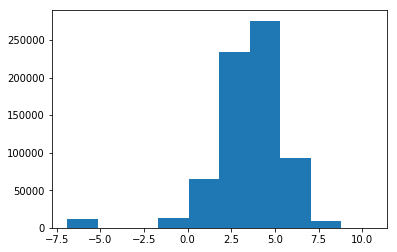

In [36]:
plt.hist(np.log(df_all['Kudos'] + 0.001))

In [46]:
a = np.asarray([0.1, 0.05, 0.7])
b = np.asarray([0.3, 0.5, 0.6])
c = np.asarray([0.2, 0.4, 0.8])

In [47]:
x = np.asarray([0.25, 0.46, 0.79])

In [43]:
np.average(spatial.distance.cosine(x, a) + spatial.distance.cosine(x, b) + spatial.distance.cosine(x, c))

0.12599571242663177

In [50]:
spatial.distance.cosine(np.mean([a, b, c], axis=0), x)

0.004970459535721727